In [1]:
import os

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torchaudio

from tqdm import tqdm, trange
import matplotlib.pyplot as plt

In [2]:
torch.cuda.empty_cache()

## Define model architecture

In [3]:
# Causal convolution modules from https://github.com/wesbz/SoundStream/blob/main/net.py
# Because I could do the math but don't want to

class CausalConv1d(nn.Conv1d):
    """
    1D convolution with padding at start only
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.causal_padding = self.dilation[0] * (self.kernel_size[0] - 1)

    def forward(self, x):
        return self._conv_forward(F.pad(x, [self.causal_padding, 0]), self.weight, self.bias)

class CausalConvTranspose1d(nn.ConvTranspose1d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.causal_padding = self.dilation[0] * (self.kernel_size[0] - 1) + self.output_padding[0] + 1 - self.stride[0]
    
    def forward(self, x, output_size=None):
        if self.padding_mode != 'zeros':
            raise ValueError('Only `zeros` padding mode is supported for ConvTranspose1d')

        assert isinstance(self.padding, tuple)
        output_padding = self._output_padding(
            x, output_size, self.stride, self.padding, self.kernel_size, self.dilation)
        return F.conv_transpose1d(
            x, self.weight, self.bias, self.stride, self.padding,
            output_padding, self.groups, self.dilation)[...,:-self.causal_padding]

In [4]:
class ResidualUnit(nn.Module):
    def __init__(self, N, dilation):
        """
        N is the number of channels (stays constant)
        dilation is Conv1d dilation for first convolution
        """
        super().__init__()
        self.conv1 = CausalConv1d(in_channels=N, out_channels=N, kernel_size=7,
                                  dilation=dilation)
        self.conv2 = CausalConv1d(in_channels=N, out_channels=N, kernel_size=1)

    def forward(self, x):
        out = F.elu(self.conv1(x))
        out = F.elu(x + self.conv2(x))
        return out

In [5]:
# Encoder architecture
class EncoderBlock(nn.Module):
    def __init__(self, N, S):
        """
        N is the number of output channels (stays constant)
            We assume the number of input channels is N/2
        S is the stride size for downsampling
        """
        super().__init__()
        self.resunits = nn.Sequential(ResidualUnit(N//2, dilation=1),
                                      ResidualUnit(N//2, dilation=3),
                                      ResidualUnit(N//2, dilation=9))
        self.conv1 = CausalConv1d(in_channels=N//2, out_channels=N, kernel_size=(2*S), stride=S)

    def forward(self, x):
        out = self.resunits(x)
        out = F.elu(self.conv1(out))
        return out

class Encoder(nn.Module):
    def __init__(self, C, D):
        """
        C is the number of channels initially
        D is the dimensionality of the encoded vectors
        """
        super().__init__()
        self.conv1 = CausalConv1d(in_channels=1, out_channels=C, kernel_size=7)
        self.encblocks = nn.Sequential(EncoderBlock(N=2*C, S=2),
                                       EncoderBlock(N=4*C, S=4),
                                       EncoderBlock(N=8*C, S=5),
                                       EncoderBlock(N=16*C, S=8))
        self.conv2 = CausalConv1d(in_channels=16*C, out_channels=D, kernel_size=3)

    def forward(self, x):
        out = F.elu(self.conv1(x))
        out = self.encblocks(out)
        out = F.elu(self.conv2(out))
        return out

In [6]:
# Decoder architecture
class DecoderBlock(nn.Module):
    def __init__(self, N, S):
        """
        N is number of channels (assumed to stay constant)
        S is stride size
        """
        super().__init__()
        self.convT1 = CausalConvTranspose1d(in_channels=N, out_channels=N//2, kernel_size=2*S,
                                            stride=S)
        self.resunits = nn.Sequential(
            ResidualUnit(N//2, dilation=1),
            ResidualUnit(N//2, dilation=3),
            ResidualUnit(N//2, dilation=9)
        )

    def forward(self, x):
        out = F.elu(self.convT1(x))
        out = self.resunits(out)
        return out

class Decoder(nn.Module):
    def __init__(self, C, D):
        """
        C is "channel scale"
        D is dimensionality of input embeddings
        """
        super().__init__()
        self.conv1 = CausalConv1d(in_channels=D, out_channels=16*C, kernel_size=7)
        self.decblocks = nn.Sequential(
            DecoderBlock(N=16*C, S=8),
            DecoderBlock(N=8*C, S=5),
            DecoderBlock(N=4*C, S=4),
            DecoderBlock(N=2*C, S=2),
        )
        self.conv2 = CausalConv1d(in_channels=C, out_channels=1, kernel_size=7)

    def forward(self, x):
        """x is the embeddings"""
        out = F.elu(self.conv1(x))
        out = self.decblocks(out)
        out = F.elu(self.conv2(out))
        return out

In [7]:
class SoundStream(nn.Module):
    def __init__(self, C_enc, C_dec, D):
        """
        C_enc: "channel scale" for encoder
        C_dec: "channel scale" for decoder
        D:     dimensionality of embeddings
        """
        super().__init__()
        self.encoder = Encoder(C_enc, D)
        self.decoder = Decoder(C_dec, D)

    def forward(self, x):
        """
        x is a waveform of shape (batch_size, 1, sequence_length)
        """
        # This will be more complicated once we get the RVQ working
        decoder_out = self.decoder(self.encoder(x))
        
        # Truncate output sequence to match input sequence length
        # return decoder_out[:,:,(decoder_out.shape[-1] - x.shape[-1]):]

        return decoder_out

Note:
- Encoder takes in tensors of shape `(n_batches, n_channels=1, seq_length)` and spits out `(n_batches, n_channels=D, ceil(seq_length/320))`
- Decoder takes in tensors of shape `(n_batches, n_channels=D, seq_length)` and spits out `(n_batches, n_channels=1, seq_length * 320)`

## Define data loader

In [8]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, cuda=True):
        self.data_dir = "./data/LibriTTS/train-clean-100-0.2s"
        self.npy_files = sorted(os.listdir(self.data_dir))[:1000]
        self.cuda = cuda

    def __len__(self):
        return len(self.npy_files)
    
    def __getitem__(self, idx):
        tensor = torch.from_numpy(np.load(f"{self.data_dir}/{self.npy_files[idx]}"))[None,:]
        if self.cuda:
            tensor = tensor.to(device="cuda")
        return tensor

In [9]:
train_data = AudioDataset()
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

In [10]:
x = next(iter(train_dataloader))

In [11]:
e = Encoder(32, 10).cuda()
e(x)

tensor([[[ 0.0228,  0.0028,  0.0611,  ...,  0.0626,  0.0619,  0.0621],
         [ 0.0207,  0.0164,  0.0439,  ..., -0.0296, -0.0298, -0.0294],
         [ 0.0035,  0.0049, -0.0175,  ..., -0.0397, -0.0395, -0.0391],
         ...,
         [-0.0092, -0.0300, -0.0067,  ..., -0.0036, -0.0032, -0.0034],
         [-0.0081, -0.0019,  0.0179,  ...,  0.0546,  0.0543,  0.0542],
         [ 0.0206,  0.0050,  0.0403,  ...,  0.0335,  0.0337,  0.0337]],

        [[ 0.0228,  0.0031,  0.0580,  ...,  0.0633,  0.0610,  0.0645],
         [ 0.0207,  0.0163,  0.0438,  ..., -0.0279, -0.0271, -0.0261],
         [ 0.0036,  0.0046, -0.0194,  ..., -0.0410, -0.0387, -0.0401],
         ...,
         [-0.0092, -0.0296, -0.0076,  ..., -0.0046, -0.0033, -0.0019],
         [-0.0080, -0.0016,  0.0177,  ...,  0.0542,  0.0540,  0.0565],
         [ 0.0205,  0.0051,  0.0400,  ...,  0.0362,  0.0369,  0.0316]],

        [[ 0.0228,  0.0012,  0.0622,  ...,  0.0634,  0.0630,  0.0606],
         [ 0.0207,  0.0166,  0.0433,  ..., -0

In [12]:
def mse_loss(output, target):
    return torch.mean((output - target)**2)

model = SoundStream(C_enc=32, C_dec=32, D=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.to(0)

epochs = 5

In [13]:
for epoch in range(epochs):
    pbar = tqdm(range(len(train_dataloader)))
    for i in pbar:
        optimizer.zero_grad()

        train_inputs = next(iter(train_dataloader))
        train_outputs = model(train_inputs)

        loss = mse_loss(train_outputs, train_inputs)
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch: {epoch:<2} --- loss: {loss.item():.5f}")

  0%|          | 0/16 [00:00<?, ?it/s]c:\Users\willi\miniforge3\envs\torch\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch: 4  --- loss: 0.00327: 100%|██████████| 16/16 [00:09<00:00,  1.65it/s]


In [14]:
torch.backends.cudnn.enabled

True

In [15]:
from IPython.display import display, Audio
display(Audio(data=train_data[0].cpu(), rate=24000))

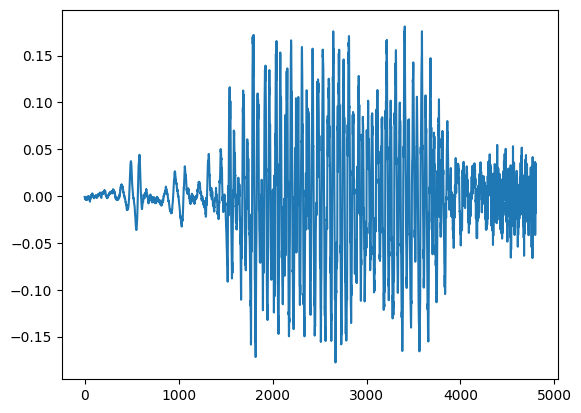

In [16]:
wave = train_data[0].cpu()
plt.plot(wave.T)

c:\Users\willi\miniforge3\envs\torch\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


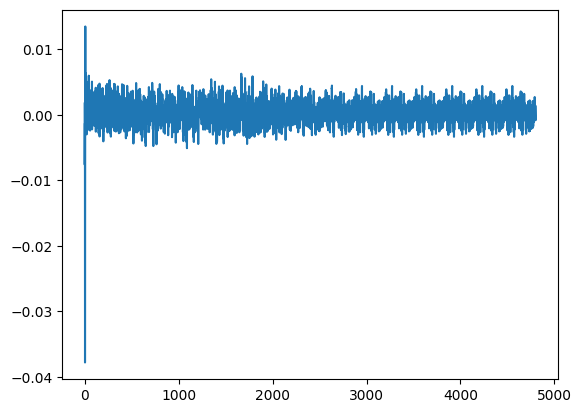

In [17]:
reconstructed = model.forward(wave.cuda())
plt.plot(reconstructed.detach().cpu().T)

In [18]:
display(Audio(data=reconstructed.detach().cpu(), rate=24000))